In [3]:
import os

import mne
from mne.baseline import rescale
from mne.stats import _bootstrap_ci

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})

In [15]:
path = 'D:\stim_code_epochs'
epoch_files = os.listdir(path)

In [10]:
np.random.seed(42)
n = np.random.randint(0,len(epoch_files))

In [12]:
epoch = mne.read_epochs(os.path.join(path, epoch_files[n]), preload = True)

Reading D:\stim_code_epochs\20140207_1219_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1949.22 ms
        0 CTF compensation matrices available
940 matching events found
Applying baseline correction (mode: mean)
940 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [13]:
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [20]:
frequency_map = list()

for band, fmin, fmax in iter_freqs:
    epoch = mne.read_epochs(os.path.join(path, epoch_files[n]), preload = True)
    filtered_epoch = epoch.filter(fmin, fmax, n_jobs=1,
                                    l_trans_bandwidth = 1,
                                    h_trans_bandwidth = 1,
                                    fir_design = 'firwin')
    filtered_epoch.subtract_evoked()
    filtered_epoch = mne.EpochsArray(filtered_epoch.get_data(), info = filtered_epoch.info,
                                      tmin = filtered_epoch.tmin)
    frequency_map.append(((band,fmin,fmax), filtered_epoch.average()))
    

Reading D:\stim_code_epochs\20140207_1219_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1949.22 ms
        0 CTF compensation matrices available
940 matching events found
Applying baseline correction (mode: mean)
940 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Setting up band-pass filter from 4 - 7 Hz
Filter length of 845 samples (3.301 sec) selected
filter_length (845) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.


<ipython-input-20-ea30b760c1bd>:8: RuntimeWarning: filter_length (845) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  fir_design = 'firwin')


Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: STI 014
[done]
940 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Reading D:\stim_code_epochs\20140207_1219_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1949.22 ms
        0 CTF compensation matrices available
940 matching events found
Applying baseline correction (mode: mean)
940 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Setting up band-pass filter from 8 - 12 Hz
Filter length of 845 samples (3.301 sec) selected
filter_length (845) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.


<ipython-input-20-ea30b760c1bd>:8: RuntimeWarning: filter_length (845) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  fir_design = 'firwin')


Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: STI 014
[done]
940 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Reading D:\stim_code_epochs\20140207_1219_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1949.22 ms
        0 CTF compensation matrices available
940 matching events found
Applying baseline correction (mode: mean)
940 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Setting up band-pass filter from 13 - 25 Hz
Filter length of 845 samples (3.301 sec) selected
filter_length (845) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.


<ipython-input-20-ea30b760c1bd>:8: RuntimeWarning: filter_length (845) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  fir_design = 'firwin')


Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: STI 014
[done]
940 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Reading D:\stim_code_epochs\20140207_1219_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1949.22 ms
        0 CTF compensation matrices available
940 matching events found
Applying baseline correction (mode: mean)
940 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Setting up band-pass filter from 30 - 45 Hz
Filter length of 845 samples (3.301 sec) selected
filter_length (845) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.


<ipython-input-20-ea30b760c1bd>:8: RuntimeWarning: filter_length (845) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  fir_design = 'firwin')


Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: STI 014
[done]
940 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5, 0, 'Time [ms]')

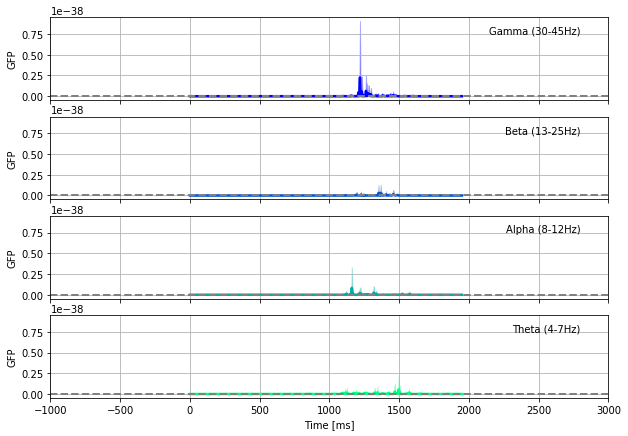

In [22]:
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = _bootstrap_ci(average.data, random_state=0,
                                  stat_fun=lambda x: np.sum(x ** 2, axis=0))
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel('Time [ms]')